In [1]:
from config import get_config
import argparse
from ShapeLearner import ShapeLearner
from ShapeLoader import ShapeDataSet
from torchvision import transforms as trans
from torch.utils.data import Dataset, ConcatDataset, DataLoader, RandomSampler
from torchvision import transforms as trans
from torchvision.datasets import ImageFolder
from PIL import Image, ImageFile
import numpy as np
import cv2
import pickle
import torch
import sys
from torch.autograd import Variable
import torch.nn.functional as F 
import matplotlib.pyplot as plt
import PIL
%matplotlib inline
from pathlib import Path
from torch import nn
from torchvision import transforms as trans
from os import path
from pathlib import Path
import os
from itertools import product
import re
from tqdm.notebook import tqdm as tqdm_notebook
import math
from functools import partial

In [2]:
conf = get_config(2)
conf.device = 'cpu'
conf.net_mode = 'resnet18'
conf.n_shapes = 1
conf.n_colors = 3
conf.shape_only = False
conf.color_only = False
learner = ShapeLearner(conf, inference=True)

2 resnet18 models generated


## generate OOD shape/color

In [3]:
def set_distractors(learner):
    # set OOD data
    triangle_ds = ShapeDataSet(no_bkg=True)
    triangle_ds.shapes = ['triangle']
    triangle_ds.colors = [[(255, 255), (0, 0), (0, 0)],
                           [(0, 0), (255, 255), (0, 0)],
                           [(0, 0), (0, 0), (255, 255)]]
    triangle_ds.n_shapes = 1
    triangle_ds.n_colors = 3
    ziped_classes = enumerate(product(range(1), range(3)))
    triangle_ds.label_map = {v:-1 for k, v in ziped_classes}
    triangle_ds.label_names = [-1]
    learner.ds = triangle_ds
    
    dloader_args = {
            'batch_size': 32,
            'pin_memory': True,
            'num_workers': conf.num_workers,
            'drop_last': False,
    }
    learner.loader = DataLoader(learner.ds, **dloader_args)
    eval_sampler = RandomSampler(learner.ds, replacement=True, num_samples=len(learner.ds) // 10)
    learner.eval_loader = DataLoader(learner.ds, sampler=eval_sampler, **dloader_args)

def set_probes(learner):
    # set OOD data
    triangle_ds = ShapeDataSet(no_bkg=True)
    triangle_ds.shapes = ['rectangle', 'circle']
    triangle_ds.colors = [[(255, 255), (0, 0), (0, 0)],
                           [(0, 0), (255, 255), (0, 0)],
                         ]#[(0, 0), (0, 0), (255, 255)]]
    triangle_ds.n_shapes = 2
    triangle_ds.n_colors = 2 # TODO fix this! we need the right 2 in the right order!
    ziped_classes = enumerate(product(range(triangle_ds.n_shapes), range(triangle_ds.n_colors)))
    triangle_ds.label_map = {v:k for k, v in ziped_classes}
    triangle_ds.label_names = [str(x) for x in product(triangle_ds.shapes, range(triangle_ds.n_colors))]
    learner.ds = triangle_ds
    
    dloader_args = {
            'batch_size': 32,
            'pin_memory': True,
            'num_workers': conf.num_workers,
            'drop_last': False,
    }
    learner.loader = DataLoader(learner.ds, **dloader_args)
    eval_sampler = RandomSampler(learner.ds, replacement=True, num_samples=len(learner.ds) // 10)
    learner.eval_loader = DataLoader(learner.ds, sampler=eval_sampler, **dloader_args)
    
def get_evaluation(learner):
    # evaluate OOD data
    for i in range(len(learner.models)):
        learner.models[i].eval()
    do_mean = -1 if len(learner.models) > 1 else 0
    ind_iter = range(do_mean, len(learner.models))
    predictions = dict(zip(ind_iter, [[] for i in ind_iter]))
    prob = dict(zip(ind_iter, [[] for i in ind_iter]))
    labels = []
    learner.eval_loader.dataset.set_mode('test')  # todo check this works :)
    for imgs, label in tqdm_notebook(learner.eval_loader, total=len(learner.eval_loader)):
        imgs = imgs.to(conf.device)
        thetas = [model(imgs).detach() for model in learner.models]
        if len(learner.models) > 1: thetas = [torch.mean(torch.stack(thetas), 0)] + thetas
        for ind, theta in zip(range(do_mean, len(learner.models)), thetas):
            val, arg = torch.max(theta, dim=1)
            predictions[ind].append(arg.cpu().numpy())
            prob[ind].append(theta.cpu().numpy())
        labels.append(label.detach().cpu().numpy())

    labels = np.hstack(labels)
    for ind in range(do_mean, len(learner.models)):
        predictions[ind] = np.hstack(predictions[ind])
        prob[ind] = np.vstack(prob[ind])
    return prob, predictions, labels

## Load Models

In [11]:
dloader_args = {
            'batch_size': 64,
            'pin_memory': True,
            'num_workers': conf.num_workers,
            'drop_last': False,
}
learner.loader = DataLoader(learner.ds, **dloader_args)
eval_sampler = RandomSampler(learner.ds, replacement=True, num_samples=len(learner.ds) // 10)
learner.eval_loader = DataLoader(learner.ds, sampler=eval_sampler, **dloader_args)

In [12]:
MODEL_DIR = 'work_space/save/shapes_pre_v2'
rel_dirs = os.listdir(MODEL_DIR)
alpha = [re.findall('a=([0-9, \.]*)_', d)[0] for d in rel_dirs if 'model' in d]
fix_str = [x for x in os.listdir(path.join(MODEL_DIR, rel_dirs[0]))][0][8:]

## evaluate OOD samples

In [7]:
def get_TTR_FTR_curve():
    open_set_1st_labels_0 = np.argmax(distractors_prob[0], 1)
    open_set_1st_labels_1 = np.argmax(distractors_prob[1], 1)
    open_set_1st_scores_0 = np.max(distractors_prob[0], 1)
    open_set_1st_scores_1 = np.max(distractors_prob[1], 1)

    mean_pred = np.argmax(prob_prob[-1], 1)
    mean_score = np.max(prob_prob[-1], 1)

    a = np.sum((open_set_1st_labels_0 == open_set_1st_labels_1))
    b = len(prob_labels)
    corr = (100.0*a / b)

    prev_FTR = -1
    prev_TTR = -1
    THs = []
    TTRs = []
    FTRs = []
    for i, TH in enumerate(np.arange(0, 1, 0.00001)):
        FTR = np.sum((open_set_1st_labels_0 == open_set_1st_labels_1) & (open_set_1st_scores_0 > TH) & (open_set_1st_scores_1 > TH)) / b
        TTR = np.sum((mean_score > TH) & (mean_pred == prob_labels)) / b

        if (prev_FTR != FTR and prev_TTR != TTR) or (i%100 == 0):
            prev_FTR = FTR
            prev_TTR = TTR
            THs.append(TH)
            TTRs.append(TTR)
            FTRs.append(FTR)
    return THs, TTRs, FTRs, corr


In [73]:
res_dir = dict.fromkeys(alpha)
for model_path, curr_alpha in zip(rel_dirs, alpha):
    conf.save_path = Path(path.join(MODEL_DIR, model_path))
    fix_str = [x for x in os.listdir(path.join(MODEL_DIR, model_path)) if 'model' in x][0][8:]
    learner.load_state(conf, fix_str, model_only=True, from_save_folder=True)
    
    # distractors
    set_distractors(learner)
    distractors_prob, distractors_predictions, distractors_labels = get_evaluation(learner)

    # probs
    set_probes(learner)
    prob_prob, prob_predictions, prob_labels = get_evaluation(learner)
    THs, TTRs, FTRs, corr = get_TTR_FTR_curve()
    print(curr_alpha, corr)
    res_dir[curr_alpha] = [THs, TTRs, FTRs, corr]


0.95 0.0



0.99 0.0



0.9 28.2



0.75 33.0



0 84.9


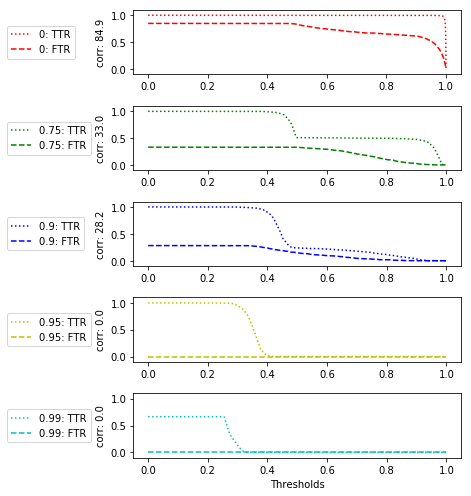

In [99]:
fig, ax = plt.subplots(5, figsize=(7,7))
ax = ax[:]
for i, (curr_alpha, curr_color) in enumerate(zip(sorted(alpha), 'rgbyc')):
    THs, TTRs, FTRs, corr = res_dir[curr_alpha]
    ax[i].plot(THs, TTRs, label=str(curr_alpha)+': TTR', color=curr_color, linestyle='dotted')
    ax[i].plot(THs, FTRs, label=str(curr_alpha)+': FTR', color=curr_color, linestyle='--')
    ax[i].legend(loc='center left', bbox_to_anchor=(-.4, 0.5))
    ax[i].set_ylim([-.1,1.1])
    ax[i].set_ylabel('corr: '+ str(corr))
plt.xlabel('Thresholds')
plt.tight_layout()

## testing attacks 

In [8]:
import torchvision.models as models
import eagerpy as ep
from foolbox import PyTorchModel, accuracy, samples
from foolbox.attacks import LinfPGD

In [9]:
for images, labels in learner.eval_loader:
    images, labels = ep.astensors(images.to('cuda'), labels.to('cuda'))
    break

In [10]:
class JointModel(torch.nn.Module):
    def __init__(self, models, device=None):
        super(JointModel, self).__init__()
        self.models = models
    
    def to(self, device):
        for model in self.models:
            model.to(device)
    
    def forward(self, x):
        res = []
        for model in self.models:
            res.append(model(x))
        return torch.stack(res, 1).mean(1)

In [30]:
class JointModelEP(torch.nn.Module):
    def __init__(self, models, device=None):
        super(JointModelEP, self).__init__()
        self.models = models
        self.bounds = models[0].bounds
    """    
    def to(self, device):
        for model in self.models:
            model.to(device)
    """
    def forward(self, x):
        res = []
        for model in self.models:
            res.append(model(x))
        return ep.stack(res, 1).mean(1)
    

In [60]:
from foolbox.attacks import FGSM, L2BasicIterativeAttack as BIM, PGD, \
                            L2CarliniWagnerAttack as CaW, EADAttack as EAD, \
                            L2BrendelBethgeAttack as MIM_maybe
# Momentum Iterative Method (MIM)
# Jacobian-based Saliency Map Attack (JSMA) 
attack_list = [
    (FGSM, 0.002),
    (FGSM, 0.004),
    (partial(BIM, rel_stepsize=0.1, steps=10), 0.01),
    (partial(BIM, rel_stepsize=0.1, steps=10), 0.02),
    (partial(PGD, rel_stepsize=0.1, steps=10), 0.01),
    (partial(PGD, rel_stepsize=0.1, steps=10), 0.02),
    #(partial(MIM_maybe, lr=0.01), 0.01),
    #(partial(MIM_maybe, lr=0.01), 0.02),
    (partial(CaW, steps=1000, stepsize=0.01), 0.001),
    (partial(CaW, steps=1000, stepsize=0.01), 0.01),
    (partial(CaW, steps=1000, stepsize=0.01), 0.1),
    (partial(EAD, steps=1000, initial_stepsize=0.01), 1),
    (partial(EAD, steps=1000, initial_stepsize=0.01), 5),
]

attack_list_names = [
    '(FGSM, 0.002)',
    '(FGSM, 0.004)',
    '(BIM, 0.01)',
    '(BIM, 0.02)',
    #'(MIM, 0.01)',
    #'(MIM, 0.02)',
    '(PGD, 0.01)',
    '(PGD, 0.02)',
    '(CaW, 0.001)',
    '(CaW, 0.01)',
    '(CaW, 0.1)',
    '(EAD, 1)',
    '(EAD, 5)'
]

In [157]:
attack_list = [
    (FGSM, [0.002, 0.004]),
    (partial(BIM, rel_stepsize=0.1, steps=10), [0.01, 0.02]),
    (partial(PGD, rel_stepsize=0.1, steps=10), [0.01, 0.02]),
    (partial(CaW, steps=1000, stepsize=0.01, confidence=0.001), [0.001]),
    (partial(CaW, steps=1000, stepsize=0.01, confidence=0.01), [0.01]),
    (partial(CaW, steps=1000, stepsize=0.01, confidence=0.1), [0.1]),
    (partial(EAD, steps=1000, initial_stepsize=0.01, confidence=1), [1]),
    (partial(EAD, steps=1000, initial_stepsize=0.01, confidence=5), [5])
    #(partial(MIM_maybe, lr=0.01), [0.01, 0.02]),
]

attack_list_names = [
    'FGSM',
    'BIM',
    'PGD',
    'CaW',
    'CaW',
    'CaW',
    'EAD',
    'EAD'
    #'(MIM, 0.01)',
    #'(MIM, 0.02)',
]

In [158]:
res = dict.fromkeys(alpha)

for model_path, curr_alpha in tqdm_notebook(zip(rel_dirs, alpha), total=len(alpha)):
    conf.save_path = Path(path.join(MODEL_DIR, model_path))
    fix_str = [x for x in os.listdir(path.join(MODEL_DIR, model_path)) if 'model' in x][0][8:]
    learner.load_state(conf, fix_str, model_only=True, from_save_folder=True)

    # probs
    set_probes(learner)

    for model in learner.models:
        model = torch.nn.DataParallel(model.cuda(), device_ids=list(range(4)))
        model.eval()
        
    res[curr_alpha] = dict()
    for (attack, eps), attack_name in tqdm_notebook(zip(attack_list, attack_list_names), 
                                                    desc='attaking '+str(curr_alpha), total=len(attack_list)):
        fmodel = JointModelEP([PyTorchModel(m, bounds=(0,1)) for m in learner.models], 'cuda')
        attack = attack()
        success_tot = []
        for images, labels in tqdm_notebook(learner.eval_loader, total=len(learner.eval_loader), desc=attack_name):
            images, labels = ep.astensors(images.to('cuda'), labels.to('cuda'))
            _, _, success = attack(fmodel, images, labels, epsilons=eps)
            success_tot.append(success)
        success_tot = ep.concatenate(success_tot, -1)

        # calculate and report the robust accuracy
        robust_accuracy = 1 - success.float32().mean(axis=-1)
        for epsilon, acc in zip(eps, robust_accuracy): 
            res[curr_alpha][attack_name+'_'+str(epsilon)] = acc.item()
        
        pickle.dump(res, open('attack_res_shape.pkl', 'wb'))
    pickle.dump(res, open('attack_res_shape.pkl', 'wb'))

KeyboardInterrupt: 

In [122]:
pd.DataFrame.from_dict(res)[sorted(alpha)]

,0,0.75,0.9,0.95,0.99
BIM,None,NaN,NaN,NaN,NaN
BIM_0.01,None,1.0,1.000,1.000,0.625
BIM_0.02,None,1.0,1.000,1.000,0.625
CaW,None,NaN,NaN,NaN,NaN
CaW_0.001,None,NaN,1.000,1.000,0.625
CaW_0.01,None,NaN,1.000,1.000,0.500
CaW_0.1,None,NaN,0.875,0.500,0.000
EAD,None,NaN,NaN,NaN,NaN
EAD_1,None,NaN,1.000,1.000,0.750
EAD_5,None,NaN,0.875,0.875,0.750


In [120]:
res

{'0.95': {'FGSM': None,
  'BIM': None,
  'PGD': None,
  'CaW': None,
  'EAD': None,
  'FGSM_0.002': 1.0,
  'FGSM_0.004': 1.0,
  'BIM_0.01': 1.0,
  'BIM_0.02': 1.0,
  'PGD_0.01': 0.0,
  'PGD_0.02': 0.0,
  'CaW_0.001': 1.0,
  'CaW_0.01': 1.0,
  'CaW_0.1': 0.5,
  'EAD_1': 1.0,
  'EAD_5': 0.875},
 '0.99': {'FGSM': None,
  'BIM': None,
  'PGD': None,
  'CaW': None,
  'EAD': None,
  'FGSM_0.002': 0.25,
  'FGSM_0.004': 0.25,
  'BIM_0.01': 0.625,
  'BIM_0.02': 0.625,
  'PGD_0.01': 0.0,
  'PGD_0.02': 0.0,
  'CaW_0.001': 0.625,
  'CaW_0.01': 0.5,
  'CaW_0.1': 0.0,
  'EAD_1': 0.75,
  'EAD_5': 0.75},
 '0.9': {'FGSM': None,
  'BIM': None,
  'PGD': None,
  'CaW': None,
  'EAD': None,
  'FGSM_0.002': 1.0,
  'FGSM_0.004': 1.0,
  'BIM_0.01': 1.0,
  'BIM_0.02': 1.0,
  'PGD_0.01': 0.0,
  'PGD_0.02': 0.0,
  'CaW_0.001': 1.0,
  'CaW_0.01': 1.0,
  'CaW_0.1': 0.875,
  'EAD_1': 1.0,
  'EAD_5': 0.875},
 '0.75': {'FGSM': None,
  'BIM': None,
  'PGD': None,
  'CaW': None,
  'EAD': None,
  'FGSM_0.002': 1.0,
  'F

In [125]:
import pickle

In [131]:
pickle.dump(res, open('attack_res_shape.pkl', 'wb'))

## using cleverhans

In [15]:
from absl import app, flags
from easydict import EasyDict
from cleverhans.future.torch.attacks import fast_gradient_method, projected_gradient_descent

In [13]:
conf.save_path = Path(path.join(MODEL_DIR, rel_dirs[0]))
fix_str = [x for x in os.listdir(path.join(MODEL_DIR, rel_dirs[0])) if 'model' in x][0][8:]
learner.load_state(conf, fix_str, model_only=True, from_save_folder=True)

In [ ]:
report = EasyDict(nb_test=0, correct=0, correct_fgm=0, correct_pgd=0)
for x, y in data.test:
    x, y = x.to(device), y.to(device)
    x_fgm = fast_gradient_method(net, x, FLAGS.eps, np.inf)
    x_pgd = projected_gradient_descent(net, x, FLAGS.eps, 0.01, 40, np.inf)
    _, y_pred = net(x).max(1)  # model prediction on clean examples
    _, y_pred_fgm = net(x_fgm).max(1)  # model prediction on FGM adversarial examples
    _, y_pred_pgd = net(x_pgd).max(1)  # model prediction on PGD adversarial examples
    report.nb_test += y.size(0)
    report.correct += y_pred.eq(y).sum().item()
    report.correct_fgm += y_pred_fgm.eq(y).sum().item()
    report.correct_pgd += y_pred_pgd.eq(y).sum().item()